# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import torch
from torch.utils.data import Dataset, DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

In [2]:
# device = ("cuda"
#     if torch.cuda.is_available()
#     else "mps"
#     if torch.backends.mps.is_available()
#     else "cpu"
# )
# print(f"Using {device} device")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device.type} device")

Using cuda device


# Download the data

In [3]:
! pip install -q kaggle

In [4]:
from google.colab import files

In [ ]:
# Upload the "kaggle.json" file
files.upload()

In [6]:
# Make directory named kaggle and copy kaggle.json file there
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

# remove the file from wd
! rm kaggle.json

# Change the permissions of the file.
! chmod 600 ~/.kaggle/kaggle.json

# Check of the file is in the folder
!ls -a ~/.kaggle/
# ! ls ../content

.  ..  kaggle.json


In [7]:
# Download Data: !kaggle competitions download -c 'name-of-competition'
! kaggle competitions download -c "nlp-getting-started"

100% 593k/593k [00:00<00:00, 714kB/s]
100% 593k/593k [00:00<00:00, 714kB/s]


In [8]:
# Create a directory named train,
! mkdir data

# unzip train data there,
! unzip nlp-getting-started.zip -d data
! rm nlp-getting-started.zip

Archive:  nlp-getting-started.zip
  inflating: data/sample_submission.csv  
  inflating: data/test.csv           
  inflating: data/train.csv          


# Import data

In [9]:
df_train_val = pd.read_csv("./data/train.csv")
df_train_val.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [10]:
df_train_val.iloc[100:105, :]

,id,keyword,location,text,target
100,144,accident,UK,.@NorwayMFA #Bahrain police had previously die...,1
101,145,accident,"Nairobi, Kenya",I still have not heard Church Leaders of Kenya...,0
102,146,aftershock,Instagram - @heyimginog,@afterShock_DeLo scuf ps live and the game... cya,0
103,149,aftershock,304,'The man who can drive himself further once th...,0
104,151,aftershock,Switzerland,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/yN...,0


In [11]:
df_train_val["keyword"].unique()

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

# Data Preprocessing

In [12]:
df_train_val["keyword"].fillna("Unknown", inplace=True)

In [13]:
df_train_val.head()

,id,keyword,location,text,target
0,1,Unknown,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,Unknown,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,Unknown,NaN,All residents asked to 'shelter in place' are ...,1
3,6,Unknown,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,Unknown,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [14]:
tokenizer = get_tokenizer("basic_english")

def yield_tokens(data):
    for k in data["keyword"]:
        yield [k]

vocab = build_vocab_from_iterator(yield_tokens(df_train_val), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [15]:
df_train_val["keyword"].unique()[:5]

array(['Unknown', 'ablaze', 'accident', 'aftershock',
       'airplane%20accident'], dtype=object)

In [16]:
# These words should be in the vocabulary
vocab(['Unknown', 'ablaze', 'accident', 'aftershock', 'airplane%20accident'])

[1, 65, 85, 116, 86]

In [17]:
# These words should NOT be in the vocabulary
vocab(["a", "b", "hello", "dog", "wertdf"])

[0, 0, 0, 0, 0]

In [18]:
print(tokenizer("accident"))
print(vocab(tokenizer("accident")))

['accident']
[85]


In [19]:
text_pipeline = lambda x: vocab(tokenizer(x))

In [20]:
example_1 = df_train_val.iloc[150, :]["keyword"]
print(example_1)
print(text_pipeline(example_1))

airplane%20accident
[86]


In [21]:
df_train, df_val = train_test_split(
    df_train_val,
    test_size=0.2,
    random_state=42,
    shuffle=True)

print(df_train_val.shape)
print(df_train.shape)
print(df_val.shape)

(7613, 5)
(6090, 5)
(1523, 5)


In [22]:
df_train.head()

,id,keyword,location,text,target
4996,7128,military,Texas,Courageous and honest analysis of need to use ...,1
3263,4688,engulfed,NaN,@ZachZaidman @670TheScore wld b a shame if tha...,0
4907,6984,massacre,Cottonwood Arizona,Tell @BarackObama to rescind medals of 'honor'...,1
2855,4103,drought,"Spokane, WA",Worried about how the CA drought might affect ...,1
4716,6706,lava,"Medan,Indonesia",@YoungHeroesID Lava Blast &amp; Power Red #Pan...,0


In [23]:
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)

# Datasets

In [24]:
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __getitem__(self, index):
        row = self.dataframe.iloc[index].to_numpy()
        features = row[1:]
        label = row[0]
        return features, label

    def __len__(self):
        return len(self.dataframe)


df_example = pd.DataFrame(np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]]),
                  columns=['label', 'feature_0', 'feature_1'])

data_example = CustomDataset(dataframe=df_example)
dataloader_example = DataLoader(data_example, batch_size=2)

for sample_example in dataloader_example:
    print(sample_example)

[tensor([[2, 3],
        [5, 6]]), tensor([1, 4])]
[tensor([[ 8,  9],
        [11, 12]]), tensor([ 7, 10])]


In [25]:
class TweetDisDataset(Dataset):

    def __init__(self, dataset, vocab, tokenizer, transform=None):
      self.keyword = dataset["keyword"]
      self.target = dataset["target"]
      self.vocab = vocab
      self.tokenizer = tokenizer
      self.transform = transform

    def __len__(self):
      return len(self.target)

    def __getitem__(self, idx):
      keyword_list = self.keyword.iloc[idx]
      keyword = [text_pipeline(token)[0] for token in [keyword_list]]
      target = self.target.iloc[idx]
      sample = {"keyword": keyword[0], "target": target}

      if self.transform:
        sample = self.transform(sample)

      return sample
      # return target

    @property
    def get_keyword(self):
      return self.keyword

In [26]:
dataset_train = TweetDisDataset(df_train, vocab, tokenizer)

print(len(dataset_train))

6090


In [27]:
dataset_train[0]

{'keyword': 136, 'target': 1}

In [28]:
dataloader = DataLoader(dataset_train, batch_size=8, shuffle=True) # batch_size=64

In [29]:
for i, key in enumerate(dataloader):
  print(key)
  break

{'keyword': tensor([ 73,  48, 138,  37, 171, 141,  90, 154]), 'target': tensor([1, 1, 1, 1, 0, 0, 0, 1])}


In [30]:
key["keyword"].shape

torch.Size([8])

In [31]:
key["keyword"].unsqueeze(1).shape

torch.Size([8, 1])

# Model

Architecture: Embedding and 2 linear layers.

Feature: "keywords"


In [32]:
len(vocab.get_itos())

223

In [33]:
vocab_size = vocab.__len__() # 223
embedding_dim = 128

In [34]:
class EmbDenseModel(torch.nn.Module):

  def __init__(self, embedding_dim, vocab_size):
    super().__init__()
    torch.manual_seed(54321)
    # vocab_size: size of the dictionary of embeddings
    # embedding_dim: size of embedding vector
    self.emb_layer = torch.nn.Embedding(vocab_size, embedding_dim)
    self.lin1 = torch.nn.Linear(embedding_dim, 64)
    self.lin2 = torch.nn.Linear(64, 32)
    self.lin3 = torch.nn.Linear(32, 1)
    #
    self.relu1 = torch.nn.ReLU()
    self.relu2 = torch.nn.ReLU()

  def forward(self, x):
    x = self.emb_layer(x)
    x = self.lin1(x)
    x = self.relu1(x) # x = torch.nn.functional.relu(x)
    x = self.lin2(x)
    x = self.relu2(x) # x = torch.nn.functional.relu(x)
    x = self.lin3(x)
    x = torch.nn.functional.sigmoid(x)
    return x

In [35]:
model_1 = EmbDenseModel(embedding_dim, vocab_size).to(device)
print(str(model_1))

EmbDenseModel(
  (emb_layer): Embedding(223, 128)
  (lin1): Linear(in_features=128, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=32, bias=True)
  (lin3): Linear(in_features=32, out_features=1, bias=True)
  (relu1): ReLU()
  (relu2): ReLU()
)


In [36]:
model_1(key['keyword'].to(device))

tensor([[0.4830],
        [0.4679],
        [0.4480],
        [0.4433],
        [0.4575],
        [0.4539],
        [0.4391],
        [0.4304]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [37]:
key['keyword']

tensor([ 73,  48, 138,  37, 171, 141,  90, 154])

## Training

In [38]:
train_dataset = TweetDisDataset(df_train, vocab, tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True) # 64?

val_dataset = TweetDisDataset(df_val, vocab, tokenizer)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=True) # 64?

In [39]:
from tqdm.notebook import tqdm

In [40]:
# Simple training loop
EPOCHS = 6
train_losses, val_losses = [], []
train_accuracy = []
val_accuracy = []

model = EmbDenseModel(embedding_dim, vocab_size)
model.to(device)

loss_fn = torch.nn.BCELoss() # Binary Cross Entropy
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(EPOCHS):

  # Training phase
  model.train()
  running_loss = 0.0

  running_acc = 0
  # for data in tqdm(train_dataloader, desc='Training loop'):
  for data in train_dataloader:

    # Get data
    keywords = data["keyword"]
    labels = data["target"]

    # Move inputs and labels to the device
    keywords = keywords.to(device)
    labels = labels.to(device)

    # Clear the gradients (because gradients are accumulated)
    optimizer.zero_grad()

    # Make predictions for this batch
    outputs = model(keywords)
    labels = labels.unsqueeze(1)
    labels = labels.float()

    # Compute the loss and its gradients
    loss = loss_fn(outputs, labels)
    optimizer.zero_grad()
    loss.backward()

    # Adjust learning weights
    optimizer.step()

    # Gather loss
    running_loss += loss.item()

    # Gather accuracy
    equals = torch.Tensor.round(outputs) == labels
    equals = equals.to(torch.float)
    # equals = torch.mean(equals)
    equals = torch.sum(equals)
    running_acc += equals

  # Store loss
  train_loss = running_loss / len(train_dataloader.dataset)
  train_losses.append(train_loss)

  # Store accuracy
  train_acc = running_acc / len(train_dataloader.dataset)
  train_accuracy.append(train_acc.item())

  # Validation phase
  model.eval() # Set the model to evaluation mode
  running_vloss = 0.0

  # Disable gradient computation and reduce memory consumption
  with torch.no_grad():
    running_acc = 0
    # for vdata in tqdm(val_dataloader, desc='Validation loop'):
    for vdata in val_dataloader:

      # Get data
      keywords = vdata["keyword"]
      labels = vdata["target"]

      # Move inputs and labels to the device
      keywords = keywords.to(device)
      labels = labels.to(device)

      # Make predictions for this batch
      outputs = model(keywords)
      labels = labels.unsqueeze(1)
      labels = labels.float()

      # Compute the loss and its gradients
      loss = loss_fn(outputs, labels)

      # Gather loss and accuracy
      running_vloss += loss.item()

      # Gather accuracy
      equals = torch.Tensor.round(outputs) == labels
      equals = equals.to(torch.float)
      # equals = torch.mean(equals)
      equals = torch.sum(equals)
      running_acc += equals

  # Store loss
  val_loss = running_vloss / len(val_dataloader.dataset)
  val_losses.append(val_loss)

  # Store accuracy
  val_acc = running_acc / len(val_dataloader.dataset)
  val_accuracy.append(val_acc.item())


  # print(f"Epoch {epoch+1}/{EPOCHS} - Train loss: {train_loss:.5f} acc: {train_acc:.5f}, Validation loss: {val_loss:.5f}")
  log_1 = f"Epoch {epoch+1}/{EPOCHS}"
  log_2 = f" - Train: loss = {train_loss:.5f};  acc = {train_acc:.2f}"
  log_3 = f" - Val: loss = {val_loss:.5f};  acc = {val_acc:.2f}"
  print(log_1 + log_2 + log_3)

Epoch 1/6 - Train: loss = 0.00520;  acc = 0.60 - Val: loss = 0.00497;  acc = 0.67
Epoch 2/6 - Train: loss = 0.00452;  acc = 0.72 - Val: loss = 0.00461;  acc = 0.72
Epoch 3/6 - Train: loss = 0.00421;  acc = 0.74 - Val: loss = 0.00447;  acc = 0.72
Epoch 4/6 - Train: loss = 0.00413;  acc = 0.74 - Val: loss = 0.00444;  acc = 0.72
Epoch 5/6 - Train: loss = 0.00410;  acc = 0.74 - Val: loss = 0.00442;  acc = 0.71
Epoch 6/6 - Train: loss = 0.00409;  acc = 0.74 - Val: loss = 0.00442;  acc = 0.72


## Loss & accuracy

In [41]:
def render_history(train_losses, val_losses, train_acc, val_acc):
  plt.figure(figsize=(10, 3))
  plt.subplot(1, 2, 1)
  plt.plot(train_losses, label="Training loss")
  plt.plot(val_losses, label="Validation loss")
  plt.ylabel("Loss")
  plt.legend(frameon=False)
  plt.subplot(1, 2, 2)
  plt.plot(train_acc, label="Training Accuracy")
  plt.plot(val_acc, label="Validation Accuracy")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

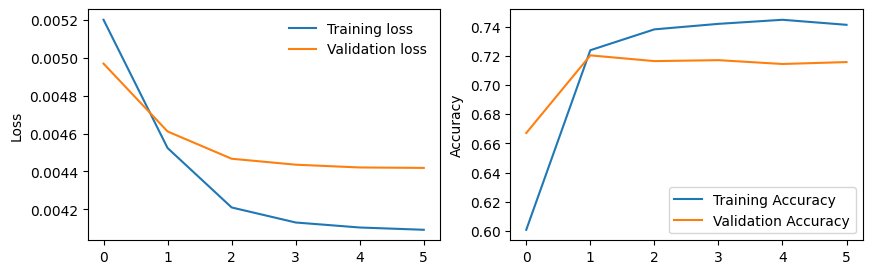

In [42]:
render_history(train_losses, val_losses, train_accuracy, val_accuracy)

In [43]:
def calc_acc(df):

  model.eval()

  X = [text_pipeline(k) for k in df["keyword"]]
  X = torch.tensor(X)
  X = X.to(device)
  X = X.squeeze()

  y_pred = model(X.squeeze())
  y_pred = y_pred.squeeze().numpy(force=True)
  y_pred = np.round(y_pred)

  y = [t for t in df["target"]]

  acc = y_pred == y
  f1 = f1_score(y, y_pred)

  return {"accuracy": acc.mean().round(3), "f1": f1.round(3)}

In [44]:
calc_acc(df_train)

{'accuracy': 0.749, 'f1': 0.703}

In [45]:
calc_acc(df_val)

{'accuracy': 0.716, 'f1': 0.667}

## Test set

For Kaggle submission

In [46]:
df_test = pd.read_csv("./data/test.csv")
df_test["keyword"].fillna("Unknown", inplace=True)

df_test.head()

,id,keyword,location,text
0,0,Unknown,NaN,Just happened a terrible car crash
1,2,Unknown,NaN,"Heard about #earthquake is different cities, s..."
2,3,Unknown,NaN,"there is a forest fire at spot pond, geese are..."
3,9,Unknown,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,Unknown,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [47]:
X_test = [text_pipeline(k) for k in df_test["keyword"]]
X_test = torch.tensor(X_test)
X_test = X_test.to(device)
X_test = X_test.squeeze()
y_test_pred = model(X_test.squeeze())
y_test_pred = y_test_pred.squeeze().numpy(force=True)
y_test_pred = y_test_pred.round()
y_test_pred

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [48]:
df_submission_1 = pd.DataFrame({
    "id": df_test.id,
    "target": y_test_pred.astype(int)
})

df_submission_1.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [49]:
df_submission_1.to_csv("./data/test_submission_1.csv", index=False)